In [1]:
# Import libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import libraries for neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

# Import libraries for normalization and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# For visualizations we will use ggplot stlye and Century Gothic as font family
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Century Gothic' 

## 1. Data processing

In [2]:
# Import the dataset
electric_generation_df = pd.read_csv('../Datasets/electric_generation_cenace_2020-2023.csv')

# Show the first rows
electric_generation_df.head()

,Date,Time,Wind,Photovoltaics,Biomass,Coal,CombinedCycle,InternalCombustion,Geothermal,Hydro,Nuclear,Thermal,Gas
0,01/01/2020,1,2063.4865,0.0,27.2993,1303.8717,15892.6664,223.6676,553.4592,1009.2008,1562.6114,1803.5191,1385.3987
1,01/01/2020,2,1854.1446,0.0,27.2328,1124.3932,15666.2708,213.9600,553.5832,830.7762,1563.6830,1796.4708,1400.2806
2,01/01/2020,3,1619.9672,0.0,25.9690,969.8357,15261.6677,209.9307,552.9112,782.0985,1563.5340,1790.3642,1400.7257
3,01/01/2020,4,1616.7096,0.0,26.3340,967.9433,14661.8918,206.6082,552.8451,678.8264,1563.1209,1785.4772,1399.7275
4,01/01/2020,5,1658.9632,0.0,25.8570,968.7607,14166.5939,205.1467,553.3489,699.4795,1563.7447,1785.2862,1382.3953


In [3]:
# Add a new column with the total energy produced per hour
electric_generation_df['Total (MWh)'] = electric_generation_df.iloc[:, 2:].sum(axis=1).astype(float)

In [4]:
# Show new dataframe
electric_generation_df.head()

,Date,Time,Wind,Photovoltaics,Biomass,Coal,CombinedCycle,InternalCombustion,Geothermal,Hydro,Nuclear,Thermal,Gas,Total (MWh)
0,01/01/2020,1,2063.4865,0.0,27.2993,1303.8717,15892.6664,223.6676,553.4592,1009.2008,1562.6114,1803.5191,1385.3987,25825.1807
1,01/01/2020,2,1854.1446,0.0,27.2328,1124.3932,15666.2708,213.9600,553.5832,830.7762,1563.6830,1796.4708,1400.2806,25030.7952
2,01/01/2020,3,1619.9672,0.0,25.9690,969.8357,15261.6677,209.9307,552.9112,782.0985,1563.5340,1790.3642,1400.7257,24177.0039
3,01/01/2020,4,1616.7096,0.0,26.3340,967.9433,14661.8918,206.6082,552.8451,678.8264,1563.1209,1785.4772,1399.7275,23459.4840
4,01/01/2020,5,1658.9632,0.0,25.8570,968.7607,14166.5939,205.1467,553.3489,699.4795,1563.7447,1785.2862,1382.3953,23009.5761


In [6]:
# Focus on '' source generation
electric_generation_df = electric_generation_df[['Date', 'Time', 'CombinedCycle']]

In [7]:
# This function creates sequences to feed the neural network
def create_sequences(data, n_steps):
    X, y = [], []
    
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    
    return np.array(X), np.array(y)

In [8]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(electric_generation_df[['CombinedCycle']])

In [9]:
# Use the last 5 hours to predict the next hour
n_steps = 5 

# Create temporaly sequences
X, y = create_sequences(data, n_steps)

# Split into train (80%) and test sets (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (sample number, temporary steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 2. Neural Network Design

In [7]:
# Initialize model
modelo = Sequential()

# Add first LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 50, return_sequences = True, activation='relu', input_shape=(X_train.shape[1], 1)))
modelo.add(Dropout(0.1))

# Add second LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 80, return_sequences = True))
modelo.add(Dropout(0.1))

# Add third LSTM layer and dropout regularization (10%)
modelo.add(LSTM(units = 50))
modelo.add(Dropout(0.1))

# Add output layer
modelo.add(Dense(units = 1))

# Compile the model
modelo.compile(optimizer = 'adam', loss='mse')

# Train the model
history = modelo.fit(X_train, y_train, epochs = 100, validation_data=(X_test, y_test))



Epoch 1/100

657/657 [==============================] - 11s 10ms/step - loss: 0.0125 - val_loss: 0.0022
Epoch 2/100
657/657 [==============================] - 6s 8ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 3/100
657/657 [==============================] - 5s 8ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 4/100
657/657 [==============================] - 6s 8ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 5/100
657/657 [==============================] - 5s 8ms/step - loss: 0.0020 - val_loss: 5.6565e-04
Epoch 6/100
657/657 [==============================] - 6s 8ms/step - loss: 0.0017 - val_loss: 7.1122e-04
Epoch 7/100
657/657 [==============================] - 5s 8ms/step - loss: 0.0015 - val_loss: 6.7650e-04
Epoch 8/100
657/657 [==============================] - 6s 8ms/step - loss: 0.0013 - val_loss: 4.7311e-04
Epoch 9/100
657/657 [==============================] - 6s 9ms/step - loss: 0.0012 - val_loss: 5.7132e-04
Epoch 10/100
657/657 [==============================] - 6s 9ms/ste

In [12]:
# Plot training and validation loss over epochs to see how well the model is converging.
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 600x400 with 0 Axes>

## 3. Results

In [13]:
# Make predictions using the test set
train_predict = modelo.predict(X_train)
test_predict = modelo.predict(X_test)

# Predictions transformed
y_train_predictions = scaler.inverse_transform(train_predict)
y_test_predictions = scaler.inverse_transform(test_predict)

# Reverse the normalization to get the real values
y_train_real = scaler.inverse_transform([y_train]).T
y_test_real = scaler.inverse_transform([y_test]).T

220/220 [==============================] - 1s 5ms/step


In [14]:
# Create a new dataframe to compare Real values vs Predicted values
predictions_df = pd.DataFrame({'Real_Value': y_test_real.flatten(), 'Prediction': y_test_predictions.flatten()})

# Add a column calculating the Relative Error
predictions_df['Error %'] = abs(predictions_df['Real_Value'] - predictions_df['Prediction'])*100/predictions_df['Real_Value']

# Add datetime column
date = electric_generation_df.iloc[int(len(electric_generation_df)*0.8) + 1:]['Date']
time = electric_generation_df.iloc[int(len(electric_generation_df)*0.8) + 1:]['Time']
predictions_df['Date'] = date.values
predictions_df['Time'] = time.values

# Show the predictions dataframe
predictions_df.head()

,Real Value,Prediction,Error %,Date,Time
0,24302.5191,24298.572266,0.016240,14/03/2023,21
1,24340.8956,24473.740234,0.545767,14/03/2023,22
2,24039.2420,24218.810547,0.746981,14/03/2023,23
3,22972.3820,23741.773438,3.349202,14/03/2023,24
4,22434.0077,22576.330078,0.634405,15/03/2023,1


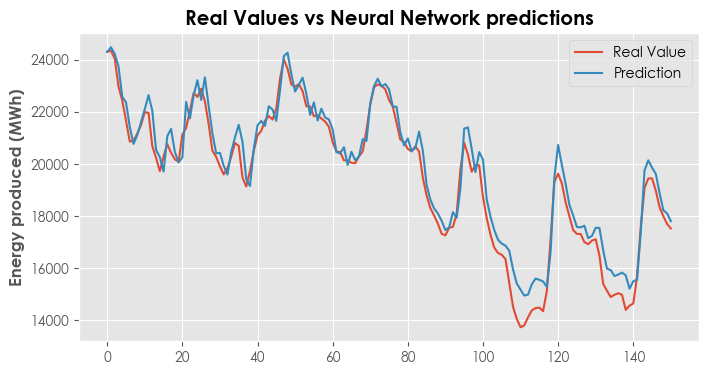

In [15]:
# For spacing reasons, plot just first 150 hours of real values and predictions in the same visualization
plt.figure(figsize = (8, 4))
plt.plot(predictions_df['Real Value'].loc[:150], label='Real Value')
plt.plot(predictions_df['Prediction'].loc[:150], label='Prediction')
plt.title('Real Values vs Neural Network predictions', fontweight = 'bold')
plt.ylabel('Energy produced (MWh)', fontweight = 'bold')
plt.legend()
plt.show()

In [16]:
# Calculate relevant metrics (RMSE, R²)
rmse_2 = np.sqrt(mean_squared_error(y_test_real, y_test_predictions))
r2_2 = r2_score(y_test_real, y_test_predictions)
mean_relative_error = predictions_df['Error %'].mean()

print(f'Root Mean Squeare Error (RMSE): {rmse_2:.3f}')
print(f'R²: {r2_2*100:.3f}%')
print(f'The relative error average for the predictions is {mean_relative_error:.3f}%')

Root Mean Squeare Error (RMSE): 460.889
R²: 97.484%
The relative error average for the predictions is 1.525%


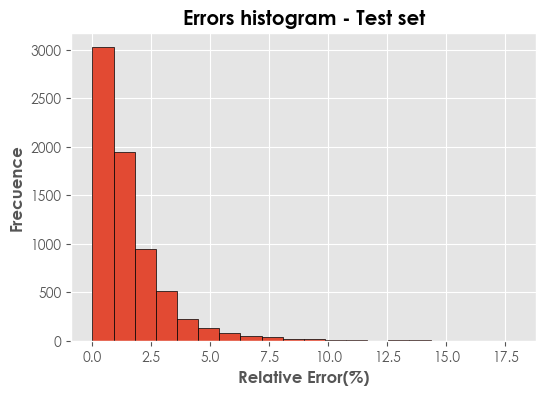

In [17]:
# Create a histogram for the test set and visualize errors shape
plt.figure(figsize = (6, 4))
plt.hist(predictions_df['Error %'], bins = 20, edgecolor = 'black')
plt.title('Errors histogram - Test set', fontweight = 'bold')
plt.xlabel('Relative Error(%)', fontweight = 'bold')
plt.ylabel('Frecuence', fontweight = 'bold')
plt.show()

## 4. Model storage

In [15]:
# Save the model as a h5 file
modelo.save('model_rnn.h5')

In [11]:
# Load the model
modelo = load_model('model_rnn.h5')
modelo.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 5, 50)             10400     
                                                                 
 dropout_27 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_32 (LSTM)              (None, 5, 80)             41920     
                                                                 
 dropout_28 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_33 (LSTM)              (None, 50)                26200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 1)               

In [19]:
# Export to csv
predictions_df.to_csv('../Datasets/predictions.csv')